First import required modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.special import digamma 

# Regression Spline
Assume that the range of x is $[a,b]$. Let the point
$$ a < \xi_1 < \dots < \xi_K < b$$
be a partion of the interval $[a,b]$  
$\left\{ \xi_1 , \dots , \xi_K \right\}$ are called knots.

Then make the function which return the knot points

In [2]:
def defineKnot(X,K=10):
    upper = max(X)
    lower = min(X)
    out = np.linspace(start=lower,stop=upper,num=K+2)[1:K+1]
    return(out)

# Radial Basis Function
A RBF $\varphi$ is a real valued function whose value depends only on the distance from origin.
A real function $\varphi : [0,\infty) \rightarrow {\rm I\!R}$ with a metric on space $\| \cdot \| : V \rightarrow [0,\infty)$ a function $\varphi_c = \varphi(\|\mathbf{x} - \mathbf{c}\|)$ is said to be a radial kernel centered at c. A radial function and the associated radial kernels are said to be radial basis function

we use radial basis functions defined by
$$
\mathbf{b}(u) = \left\{  u, \left| \frac{u-\tau_1}{c} \right|^3 , \cdots , \left| \frac{u-\tau_K}{c} \right|^3 \right\}
$$
where $c$ is sample standard deviation 

Then we can make the function which retrun the basis

In [3]:
def b(u,tau,sd):
    lst = []
    lst.append(u)
    for i in tau:
        lst.append(abs((u-i)/sd)**3)
    out = np.array(lst)
    return(out)

Nonparametric linear model can be represented as
$$ Y = \mathbf{b}(X) \boldsymbol{\beta} + \varepsilon$$
where $Y \in  {\rm I\!R}^{n\times1}, X \in  {\rm I\!R}^{n\times1}$ and $\varepsilon \sim N(0,\tau^{-1})$

# Make toy data

Let
$$y = 3\exp\left(-200(x-0.2)^2\right) + \exp\left(-50(x-0.6)^2\right)$$

Plotting true distribution of $Y$ is

In [4]:
x = np.linspace(0,1,300)
y = 3*np.exp(-200*(x-0.2)**2) + np.exp(-50*(x-0.6)**2)

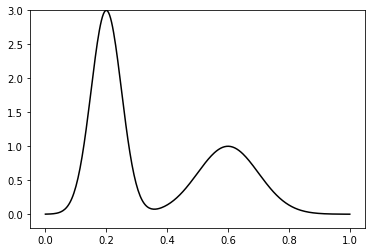

In [5]:
x = np.linspace(0,1,300)
y=f(x)
plt.plot(x, y, 'k')
plt.ylim(-0.2, 3)
plt.show()

make the simulation function which make the obs with error $N(0,0.5)$

In [6]:
def mkToy(n=300,tau = 0.5):
    x = np.random.uniform(size = n)
    e = np.random.normal(0,np.sqrt(0.5), size= n)
    y = 3*np.exp(-200*(x-0.2)**2) + np.exp(-50*(x-0.6)**2) + e
    #out = np.column_stack([x,y])
    return(x,y)

Plotting the distribution of simulated data
$$y = 3\exp\left(-200(x-0.2)^2\right) + \exp\left(-50(x-0.6)^2\right) + \varepsilon$$
where $\varepsilon \sim N(0,0.5)$

In [7]:
x,y = mkToy()

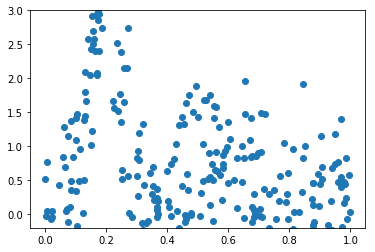

In [8]:
plt.plot(x,y,'o')
plt.ylim(-0.2, 4)
plt.show()

Calculate the standard deviation of observed data

In [9]:
sd = np.std(x)
print(sd)

0.29923910225377626


Define the knot and design matrix

In [10]:
knot = defineKnot(x)
d_x = b(x,knot,sd).T

plotting the fitted value

In [11]:
fitted  = d_x.dot(np.linalg.inv(d_x.T.dot(d_x))).dot(d_x.T).dot(y)

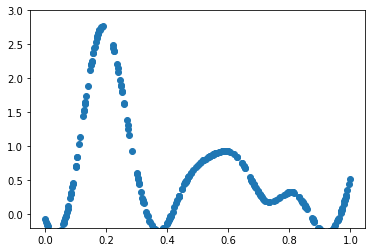

In [12]:
plt.plot(x,fitted,'o')
plt.ylim(-0.2, 3)
plt.show()

In [13]:
def mfvb(X,y,max_iter):
    N,p = X.shape
    a ,b, c, d = [10**(-7)]*4
    
    a_tilde = np.repeat(a + 0.5, p)
    b_tilde = np.repeat(b,p)
    c_tilde = c + (N+1)/2
    d_tilde = d
    
    mu_coeffs = np.repeat(0,p)
    sigma_coeffs = np.diag(np.repeat(1,p))
    

    for i in range(max_iter):
        expected_coeffs = mu_coeffs
        double_expected_coeffs = sigma_coeffs + mu_coeffs.dot(mu_coeffs.T)
        diagonal_sigma = np.diag(sigma_coeffs)
        expected_alpha = np.array(list(map(lambda x : a_tilde[x]/b_tilde[x] , np.arange(0,p))))
        log_expected_alpha = np.array(list(map(lambda x : digamma(a_tilde[x])-np.log(b_tilde[x]) , np.arange(0,p))))
        expected_tau = c_tilde / d_tilde
        log_expected_tau = digamma(c_tilde)-np.log(d_tilde)
        sigma_coeffs = np.linalg.inv(np.diag(expected_alpha)+expected_tau*(X.T.dot(X)))
        mu_coeffs =  expected_tau*sigma_coeffs.dot(X.T.dot(y))
        b_tilde = np.array(list(map(lambda x : (diagonal_sigma[x]+mu_coeffs[x]**2)/2 + b , np.arange(0,p))))
        d_tilde = d+0.5*(y.T.dot(y)) - expected_coeffs.T.dot((X.T.dot(y))+ 0.5*sum(np.diag(X.dot(double_expected_coeffs).dot(X.T))))
    return mu_coeffs,sigma_coeffs

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log


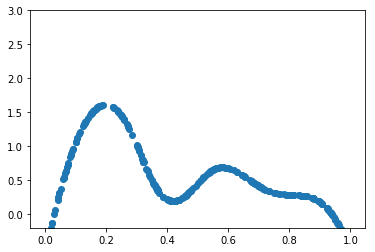

In [19]:
m,c = mfvb(d_x,y, max_iter= 1000)
plt.plot(x,d_x.dot(m),'o')
plt.ylim(-0.2, 3)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log


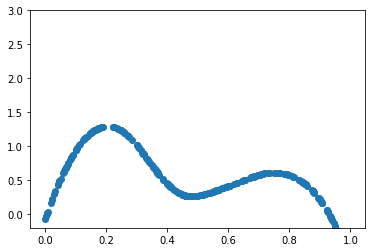

In [16]:
m,c = mfvb(d_x,y, max_iter= 100000)
plt.plot(x,d_x.dot(m),'o')
plt.ylim(-0.2, 3)
plt.show()